# Insight Data

In [177]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import tqdm

df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")



# hitung frekuensi kemunculan
counts = df["SMILES"].value_counts()

# filter yang muncul lebih dari 1
lebih_dari_satu = counts[counts > 1]

print(lebih_dari_satu)

Series([], Name: count, dtype: int64)


In [178]:
def outlier(df):
    numerik = df.select_dtypes(include=["int64", "float64"]).columns

    # Cuma kolom Smile
    categorik = df.select_dtypes(exclude=["int64", "float64"]).columns

    outlier_summary = []

    for col in numerik:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # hitung jumlah outlier
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = outliers.shape[0]
        percent = (n_outliers / df.shape[0]) * 100

        if percent > 0.1:
            outlier_summary.append([col, n_outliers, round(percent, 2)])
            
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

        
    
    # simpan jadi DataFrame ringkasan
    outlier_df = pd.DataFrame(outlier_summary, columns=["Kolom", "Jumlah Outlier", "Persentase (%)"])
    print(outlier_df)



outlier(df.drop(columns="Tm"))
outlier(df_test)


         Kolom  Jumlah Outlier  Persentase (%)
0      Group 1              34            1.28
1      Group 2             464           17.43
2      Group 3             233            8.75
3      Group 4              87            3.27
4      Group 5              89            3.34
..         ...             ...             ...
241  Group 409               5            0.19
242  Group 412              16            0.60
243  Group 414              19            0.71
244  Group 415               3            0.11
245  Group 418               3            0.11

[246 rows x 3 columns]
         Kolom  Jumlah Outlier  Persentase (%)
0      Group 1               9            1.35
1      Group 2             109           16.37
2      Group 3              62            9.31
3      Group 4              30            4.50
4      Group 5              22            3.30
..         ...             ...             ...
240  Group 408               4            0.60
241  Group 409               3      

In [179]:
def handle_outlier(df):
    outlier_summary = []

    numerik = df.select_dtypes(include=["int64", "float64"]).columns

    # Cuma kolom Smile
    categorik = df.select_dtypes(exclude=["int64", "float64"]).columns

    for col in numerik:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # hitung jumlah outlier
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = outliers.shape[0]
        percent = (n_outliers / df.shape[0]) * 100

        if percent > 0.1:
            outlier_summary.append([col, n_outliers, round(percent, 2)])
            
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

        
    
    # simpan jadi DataFrame ringkasan
    outlier_df = pd.DataFrame(outlier_summary, columns=["Kolom", "Jumlah Outlier", "Persentase (%)"])
    print(outlier_df)


handle_outlier(df.drop(columns="Tm"))
handle_outlier(df_test)


         Kolom  Jumlah Outlier  Persentase (%)
0      Group 1              34            1.28
1      Group 2             464           17.43
2      Group 3             233            8.75
3      Group 4              87            3.27
4      Group 5              89            3.34
..         ...             ...             ...
241  Group 409               5            0.19
242  Group 412              16            0.60
243  Group 414              19            0.71
244  Group 415               3            0.11
245  Group 418               3            0.11

[246 rows x 3 columns]
Empty DataFrame
Columns: [Kolom, Jumlah Outlier, Persentase (%)]
Index: []


In [180]:
missing = []

for i in df.columns :
    if df[i].isnull().sum() > 0 :
        missing.append(i)
        
print(f"{missing} gada missing value")

for i in df_test.columns :
    if df_test[i].isnull().sum() > 0 :
        missing.append(i)
        
print(f"{missing} gada missing value")


[] gada missing value
[] gada missing value


In [181]:
train = df.drop(columns="Tm")
valid = df["Tm"]

X_train, X_valid, y_train, y_valid = train_test_split(
    train,
    valid,
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# --- FIT SEKALI DI TRAIN ---
X_train_enc = encoder.fit_transform(X_train[["SMILES"]])
X_valid_enc = encoder.transform(X_valid[["SMILES"]])
X_test_enc  = encoder.transform(df_test[["SMILES"]])

# --- UBAH JADI DATAFRAME ---
X_train_df = pd.DataFrame(
    X_train_enc,
    columns=encoder.get_feature_names_out(["SMILES"]),
    index=X_train.index
)

X_valid_df = pd.DataFrame(
    X_valid_enc,
    columns=encoder.get_feature_names_out(["SMILES"]),
    index=X_valid.index
)

X_test_df = pd.DataFrame(
    X_test_enc,
    columns=encoder.get_feature_names_out(["SMILES"]),
    index=df_test.index
)

# Kalau mau gabung dengan fitur lain (numerik dsb.)
X_train = pd.concat([X_train.drop(columns=["SMILES"]), X_train_df], axis=1)
X_valid = pd.concat([X_valid.drop(columns=["SMILES"]), X_valid_df], axis=1)
df_test = pd.concat([df_test.drop(columns=["SMILES"]), X_test_df], axis=1)




In [182]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

print(mean_absolute_error(y_valid, y_pred))

37.97471819887428


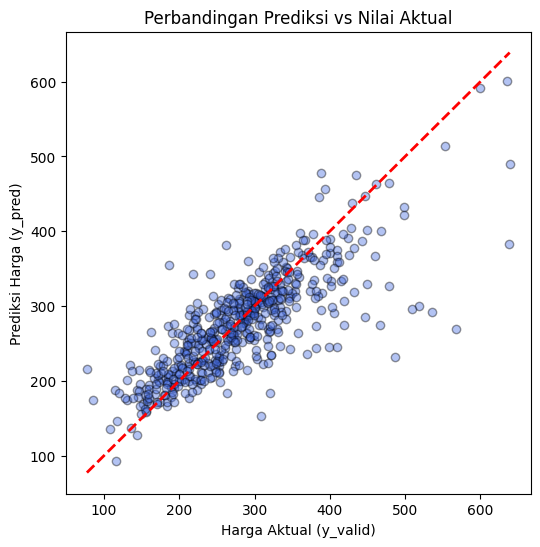

In [183]:
import matplotlib.pyplot as plt

# Prediksi pakai model terbaik (misalnya Random Forest)
y_pred = gb_model.predict(X_valid)

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_pred, alpha=0.4, color="royalblue", edgecolor="k")

# Garis y=x sebagai pembanding (prediksi sempurna)
max_val = max(max(y_valid), max(y_pred))
min_val = min(min(y_valid), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.xlabel("Harga Aktual (y_valid)")
plt.ylabel("Prediksi Harga (y_pred)")
plt.title("Perbandingan Prediksi vs Nilai Aktual")
plt.show()


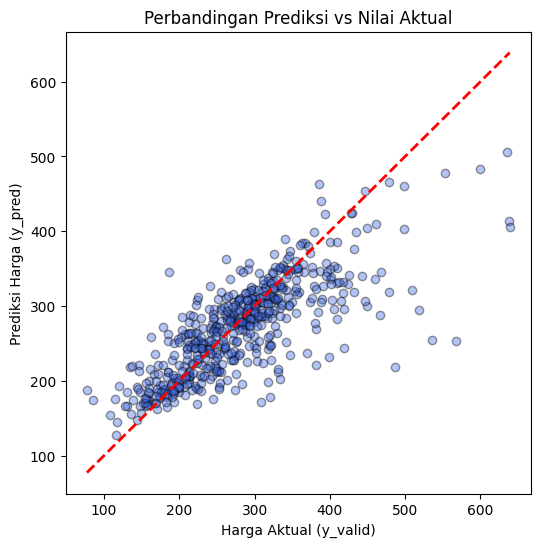

In [184]:
import matplotlib.pyplot as plt

# Prediksi pakai model terbaik (misalnya Random Forest)
y_pred = rf_model.predict(X_valid)

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_valid, y_pred, alpha=0.4, color="royalblue", edgecolor="k")

# Garis y=x sebagai pembanding (prediksi sempurna)
max_val = max(max(y_valid), max(y_pred))
min_val = min(min(y_valid), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.xlabel("Harga Aktual (y_valid)")
plt.ylabel("Prediksi Harga (y_pred)")
plt.title("Perbandingan Prediksi vs Nilai Aktual")
plt.show()


In [185]:
# Prediksi
preds = model.predict(df_test)

# Buat submission file
submission = pd.DataFrame({
    "id": df_test["id"],
    "Tm": preds
})

submission.to_csv("submission.csv", index=False)
print("File submission.csv berhasil dibuat!")


File submission.csv berhasil dibuat!
